In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
df = pd.read_csv('C:\\Users\\Ufuk Altan\\Downloads\\Downloads\\Data Science\\DATA\\RSCCASN.csv')
df.head()

,DATE,RSCCASN
0,1992-01-01,6938
1,1992-02-01,7524
2,1992-03-01,8475
3,1992-04-01,9401
4,1992-05-01,9558


In [5]:
df = pd.read_csv('C:\\Users\\Ufuk Altan\\Downloads\\Downloads\\Data Science\\DATA\\RSCCASN.csv', parse_dates=True, index_col='DATE')
df.columns =['Sales']

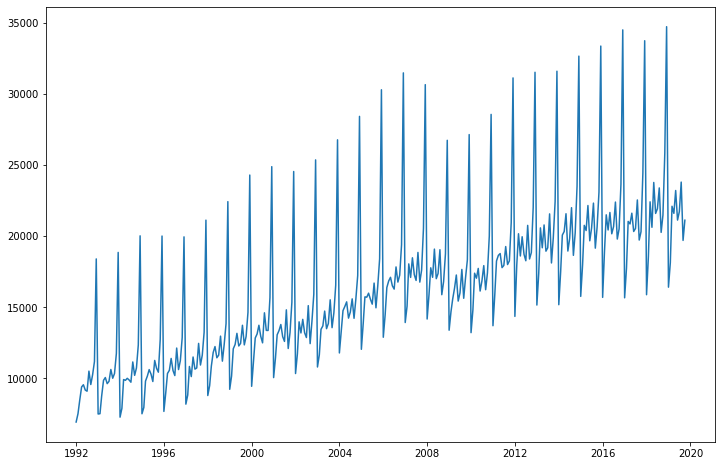

In [8]:
plt.figure(figsize=(12,8))
plt.plot(df)

In [10]:
len(df)

334

In [14]:
test_size = 18
test_ind = len(df) - test_size

In [17]:
train= df.iloc[:test_ind]
test = df.iloc[test_ind:]

In [22]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [23]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

length = 12

generator = TimeseriesGenerator(scaled_train,scaled_train,length=length,batch_size=1)

In [25]:
X,y = generator[0]
X

array([[[0.        ],
        [0.02127505],
        [0.05580163],
        [0.08942056],
        [0.09512053],
        [0.08146965],
        [0.07860151],
        [0.12979233],
        [0.09566512],
        [0.1203892 ],
        [0.15426227],
        [0.41595266]]])

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

In [28]:
n_features = 1

In [29]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (length,n_features)))

model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam')

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [31]:
from tensorflow.keras.callbacks import EarlyStopping

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [33]:
validation_generator = TimeseriesGenerator(scaled_test, scaled_test,
                                          length=length, batch_size=1)

In [34]:
model.fit_generator(generator, epochs=20,
                   validation_data=validation_generator,callbacks=[early_stop])

Epoch 1/20
304/304 [==============================] - 25s 81ms/step - loss: 0.0234 - val_loss: 0.0038
Epoch 2/20
304/304 [==============================] - 18s 60ms/step - loss: 0.0156 - val_loss: 0.0028
Epoch 3/20
304/304 [==============================] - 23s 76ms/step - loss: 0.0082 - val_loss: 0.0183
Epoch 4/20
304/304 [==============================] - 24s 78ms/step - loss: 0.0037 - val_loss: 0.0034
Epoch 5/20
304/304 [==============================] - 20s 67ms/step - loss: 0.0027 - val_loss: 4.8586e-04
Epoch 6/20
304/304 [==============================] - 26s 87ms/step - loss: 0.0031 - val_loss: 0.0017
Epoch 7/20
304/304 [==============================] - 19s 64ms/step - loss: 0.0025 - val_loss: 0.0054
Epoch 8/20
304/304 [==============================] - 14s 46ms/step - loss: 0.0015 - val_loss: 3.3710e-04
Epoch 9/20
304/304 [==============================] - 15s 50ms/step - loss: 0.0013 - val_loss: 6.3529e-04
Epoch 10/20
304/304 [==============================] - 15s 49ms/step -

In [35]:
losses = pd.DataFrame(model.history.history)

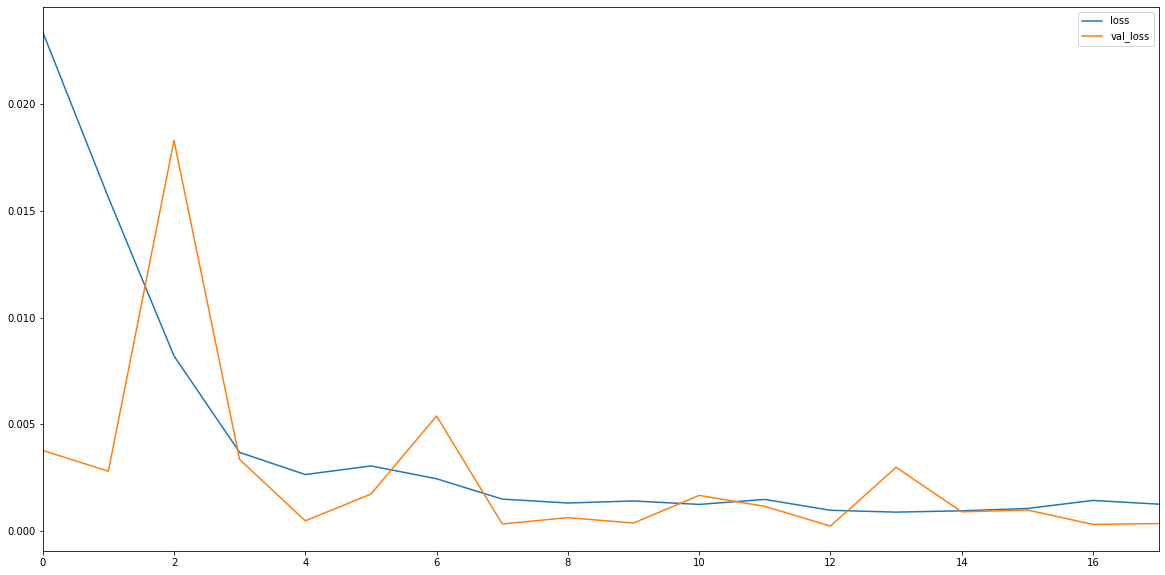

In [36]:
losses.plot(figsize=(20,10))

In [37]:
test_predictions = []
first_eval_batch= scaled_train[-length:] #Select what to predict with! 
current_batch = first_eval_batch.reshape((1,length,n_features)) # Format correctly

for i in range(len(test)):
    
    #Do the prediction
    current_pred = model.predict(current_batch)[0]
    
    #Add the prediction to a list before going to the next prediction
    test_predictions.append(current_pred)

    #Go for the next prediction
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)


In [38]:
predictions = scaler.inverse_transform(test_predictions)

In [39]:
test['Predictions'] = predictions

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [41]:
def percentage_error(dataframe,pred, true_value):
    
    '''
    dataframe: Pass in pandas dataframe variable
    pred = dataframe['Predictions'] #model.predict(x_test).reshape()
    true_value = dataframe['True Values'] #y_test
    
    '''
    
    difference = true_value - pred
    
    dataframe['Error(%)']= np.absolute(difference/true_value*100)
    
    print('Average Percentage Error is: {}'.format(dataframe['Error(%)'].mean()))

In [43]:
percentage_error(test,test['Predictions'],test['Sales'] )

Average Percentage Error is: 4.2970163137123745


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


In [45]:
test.describe()

,Sales,Predictions,Error(%)
count,18.000000,18.000000,18.000000
mean,22321.833333,21463.970148,4.297016
std,3762.960337,3428.030882,2.007227
min,16410.000000,15913.772510,1.109910
25%,21115.500000,20349.882885,2.925954
50%,21655.500000,20657.720513,4.325355
75%,23335.750000,22032.496386,5.214798
max,34706.000000,33254.817892,8.881091


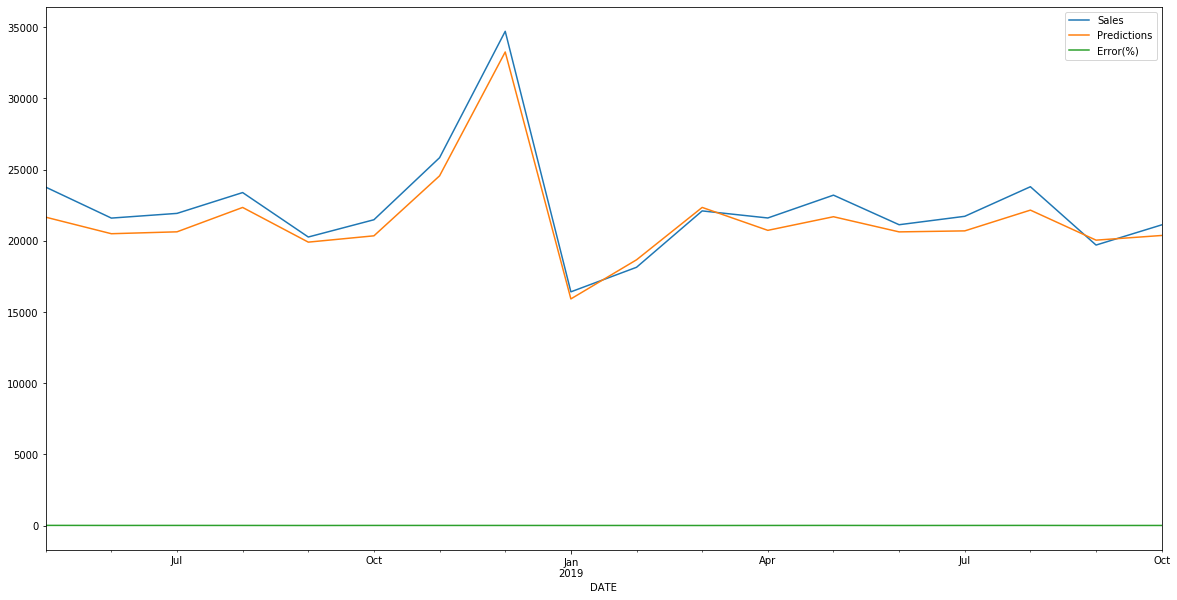

In [46]:
test.plot(figsize=(20,10))

In [62]:
scaler_full = MinMaxScaler()
data = scaler_full.fit_transform(df)

In [63]:
batch = 12

generator = TimeseriesGenerator(data, data,length=batch,batch_size=1)

In [48]:
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape = (length,n_features)))

model.add(Dense(1))

model.compile(loss='mse', optimizer = 'adam')

In [49]:
model.fit_generator(generator, epochs=8)

Epoch 1/8
304/304 [==============================] - 36s 119ms/step - loss: 0.0262
Epoch 2/8
304/304 [==============================] - 38s 125ms/step - loss: 0.0177
Epoch 3/8
304/304 [==============================] - 29s 95ms/step - loss: 0.0152
Epoch 4/8
304/304 [==============================] - 30s 98ms/step - loss: 0.0176
Epoch 5/8
304/304 [==============================] - 35s 117ms/step - loss: 0.0096
Epoch 6/8
304/304 [==============================] - 37s 121ms/step - loss: 0.0043
Epoch 7/8
304/304 [==============================] - 35s 115ms/step - loss: 0.0029
Epoch 8/8
304/304 [==============================] - 36s 119ms/step - loss: 0.0019


In [66]:
forecast = []
periods = 12

first_eval_batch= scaled_train[-length:] #Select what to predict with! 
current_batch = first_eval_batch.reshape((1,length,n_features)) # Format correctly

for i in range(periods):
    
    #Do the prediction
    current_pred = model.predict(current_batch)[0]
    
    #Add the prediction to a list before going to the next prediction
    forecast.append(current_pred)

    #Go for the next prediction
    current_batch = np.append(current_batch[:,1:,:], [[current_pred]], axis=1)


In [67]:
forecast = scaler_full.inverse_transform(forecast)

In [68]:
forecast_index = pd.date_range(start='2019-11-01',periods=periods,freq='MS')

In [69]:
forecast_index

DatetimeIndex(['2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01',
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01'],
              dtype='datetime64[ns]', freq='MS')

In [70]:
forecasts = pd.DataFrame(data=forecast,index=forecast_index,columns=['Forecast'])

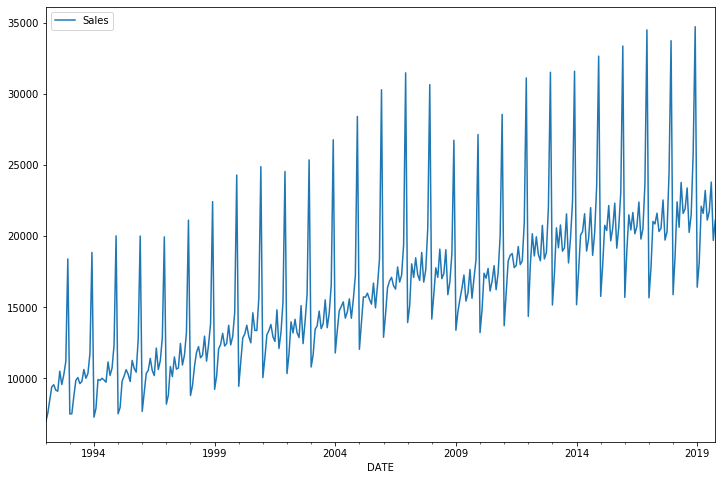

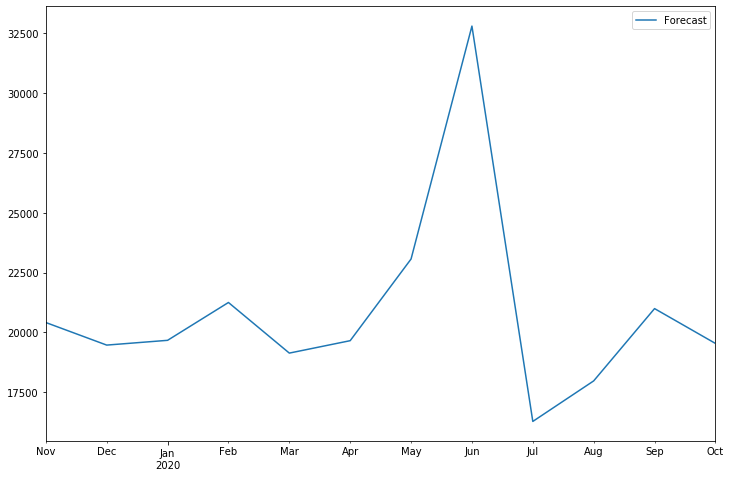

In [71]:
df.plot(figsize=(12,8))
forecasts.plot(figsize=(12,8))

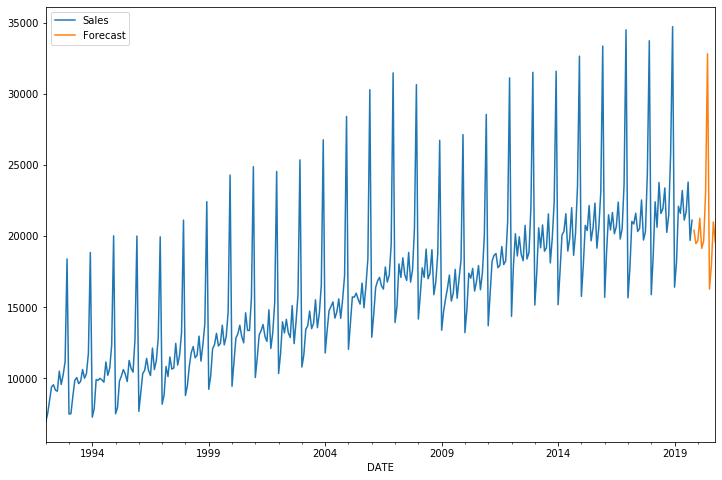

In [72]:
ax = df.plot()
forecasts.plot(ax=ax,figsize=(12,8))

(576, 611)

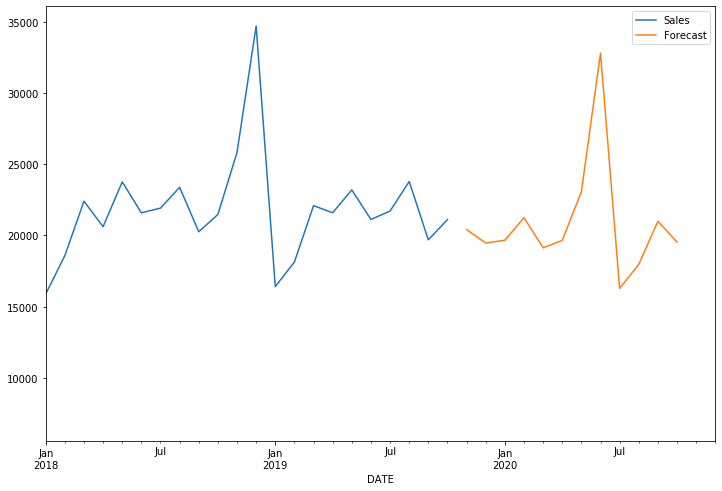

In [73]:
ax = df.plot()
forecasts.plot(ax=ax,figsize=(12,8))
plt.xlim('2018-01-01','2020-12-01')